In [61]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import csv

In [62]:
imsInputDir = '/Users/alonhrl/Documents/Alon/MA-MSC/development/ims-data/9-21-4-22-months-data/'
barIlanInputDir = '/Users/alonhrl/Documents/Alon/MA-MSC/development/Bar-Ilan data/'

In [63]:
def get_file_month_year(fileName):
    #extract last part in the file name which is the date
    filename = os.path.basename(fileName)
    tempTuple = os.path.splitext(filename)
    filename = tempTuple[0]
    fileNameArr = np.array(filename.split("-"))
        
    #the format is name-mm-yy
    month = int(fileNameArr[1])
    year = int(fileNameArr[2])
    
    return month, year

In [64]:
def generate_ims_day_radiation_array(fileName):
    rdata = np.genfromtxt(fileName, delimiter=',', missing_values=0)
    rdata = rdata.astype('int32')
    
    #clear any noise
    with np.nditer(rdata, op_flags=['readwrite']) as it:
        for x in it:
            if x<0 or x>10000:
                x[...] = 0
       
    #remove upper row which are the hours
    rdata = rdata[1:]
  
    #calculate accumulated radiation per day
    dsum = rdata.sum(axis=1)
    
    # Add the days row
    row, col = rdata.shape
    days = np.empty(row, dtype=object)
    for x in range(row):
        days[x] = x+1

    daySum = np.vstack([days, dsum])
    
    return daySum

In [65]:
def generate_bar_Ilan_day_radiation_array(fileName):
    barIlanData = np.genfromtxt(fileName, delimiter=',', dtype=np.int16)
    barIlanData = barIlanData.astype('int16')

    #remove upper row which are the hours
    barIlanData_skip_first = barIlanData[1:]

    # Calculate sum along axis 1 (columns) for the modified array
    barIlandSum = barIlanData_skip_first.sum(axis=1)
        
    return barIlandSum

In [66]:
def find_matching_barIlan_file(req_month, req_year):
    for dirpath, dirs, files in os.walk(barIlanInputDir):
        for filename in files:
            fname = os.path.join(dirpath,filename)
            file_name, file_extension = os.path.splitext(filename)
            if file_extension == '.csv':
                month, year = get_file_month_year(file_name)
                if((month == req_month) and (year == req_year)):
                    return fname

In [67]:
def calculate_rmse(measured, predicted):
   
    MSE = np.square(np.subtract(measured,predicted)).mean() 
    RMSE = math.sqrt(MSE)
    return int(RMSE)

In [68]:
def write_rmse_to_file(rmse_file, data):
   # Read the contents of the existing CSV file
    with open(rmse_file, 'r') as file:
        reader = csv.reader(file)
        lines = list(reader)

        # Append the new line to the content
        lines.append(data)

    # Write the updated content back to the CSV file
    with open(rmse_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(lines)

In [69]:
def plot_radiation_graph(month, year, imsDaySum, emetsatDaySum, fileToSave, rmse):
    x = imsDaySum[0]
    ims_daily = imsDaySum[1]
    eumetsat_daily = emetsatDaySum

    fig, ax = plt.subplots()

    x = imsDaySum[0]
    ax.plot(x, eumetsat_daily, "-b" ,label="Bar-Ilan_daily")
    ax.plot(x, ims_daily, "-r", label="ims_daily")
    ax.set_xticks(np.arange(0, len(x)+1, 1))
    ax.set_xlabel('days', fontsize=14)
    ax.set_ylabel('rad', fontsize=14)
        
    title = 'Daily radiation %d/%d (RMSE: %d)' % (int(month), int(year), rmse)
    fig.suptitle(title, fontsize=14)
   
    plt.rc('legend', fontsize=14)
    plt.legend(loc="upper left")
    plt.rcParams["figure.figsize"] = (20,8)
    plt.rcParams.update({'font.size': 12})
    ##plt.rc('xtick', labelsize=8)
    plt.draw()
    plt.savefig(fileToSave)

##### Add Eumetsat daily radiation

## Compare radiaition data of ims and eumetsat

The file suffix name of the ims data and the Eumetsat data are equal mm-yy. 
For each ims monthly data file, get the matching Eumetsat monthly data file 

Processing: /Users/alonhrl/Documents/Alon/MA-MSC/development/ims-data/9-21-4-22-months-data/ims-09-21.csv
imsDaySum
[[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
  28 29 30]
 [6503 6682 6830 6909 6677 6166 6287 6862 6545 5338 6276 5960 6357 6174
  6115 5280 6254 6426 6345 6153 6264 5913 5682 4782 6264 5954 4888 5578
  5598 5501]]
Found Bar-Ilan matching file: /Users/alonhrl/Documents/Alon/MA-MSC/development/Bar-Ilan data/bar_ilan-09-21.csv
barIlanDaySum
[5919 6193 6191 6251 5848 5867 5824 6182 5926 4430 5410 5134 5847 5794
 5789 5352 5990 5831 5993 5767 5774 5590 5263 4330 5930 5656 4512 5207
 5313 5345]
done!
Processing: /Users/alonhrl/Documents/Alon/MA-MSC/development/ims-data/9-21-4-22-months-data/ims-03-22.csv
imsDaySum
[[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
  28 29 30 31]
 [4948 4178 2812 5371 5543 4011 5072 4145 4101 4998 3147 2371 3441 4818
  5014 5479 5919 1525 5022 4968 2613 6440 6301 3081 4717 6627 6743 5114
  632

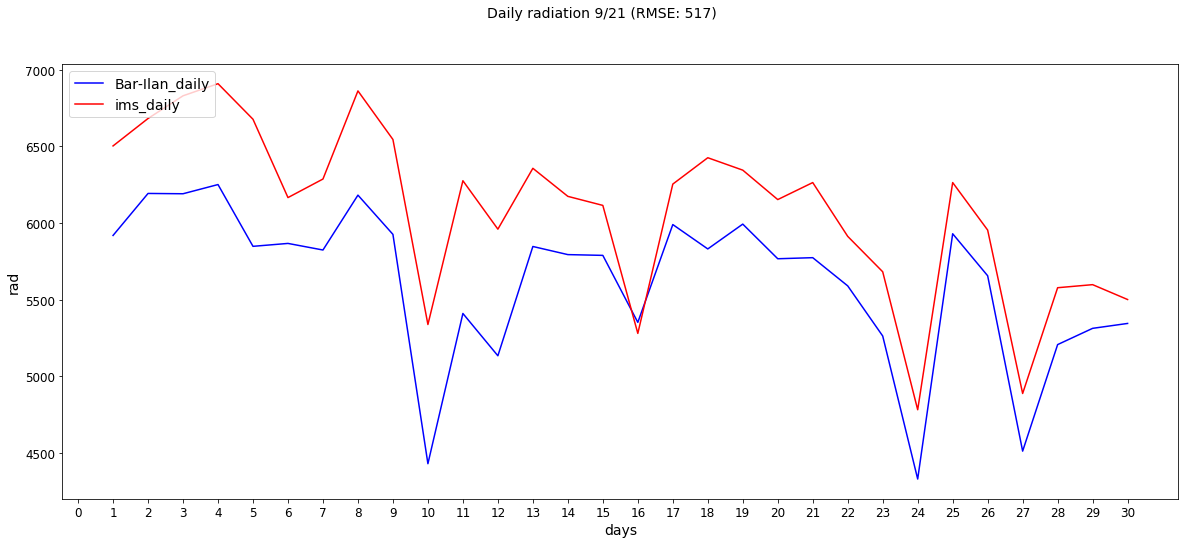

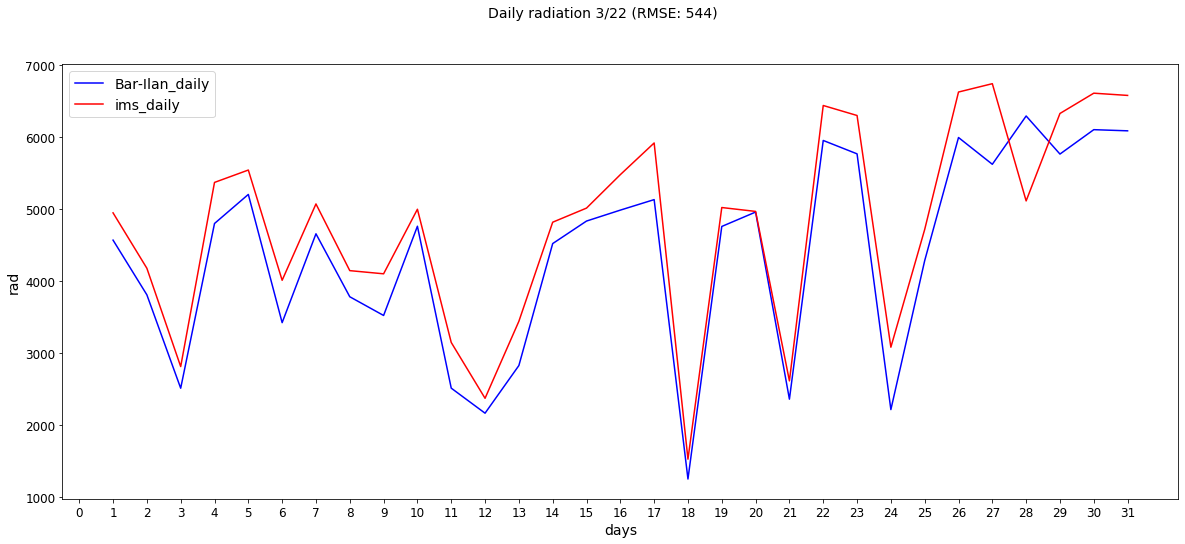

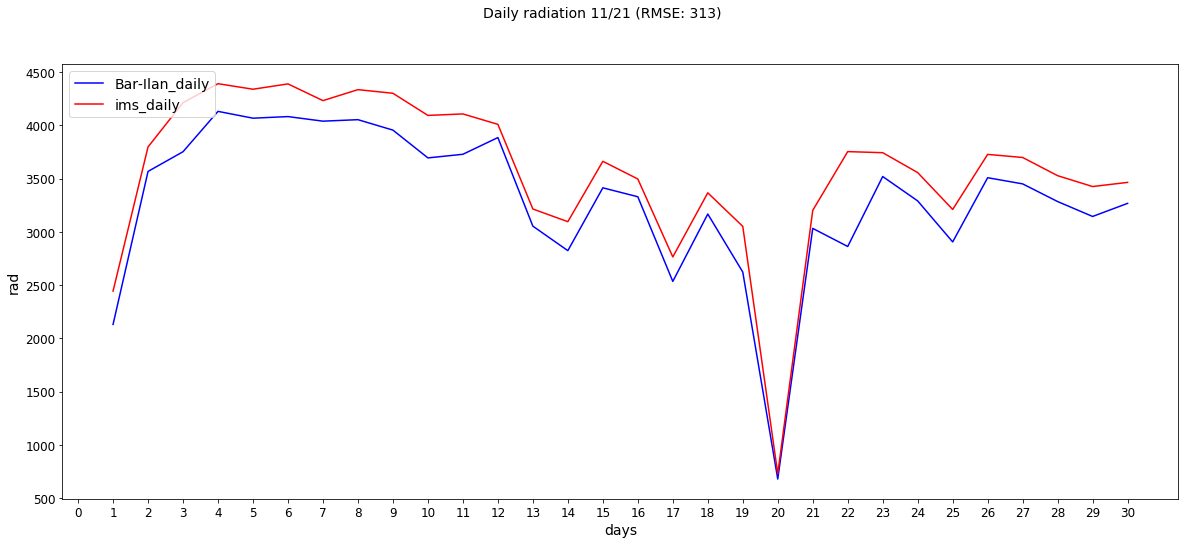

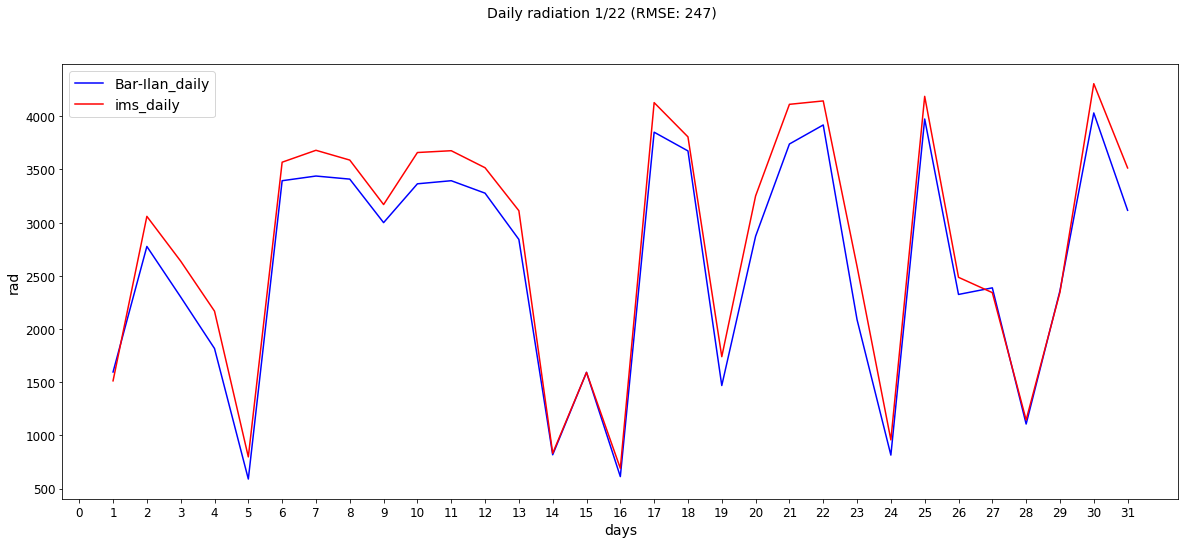

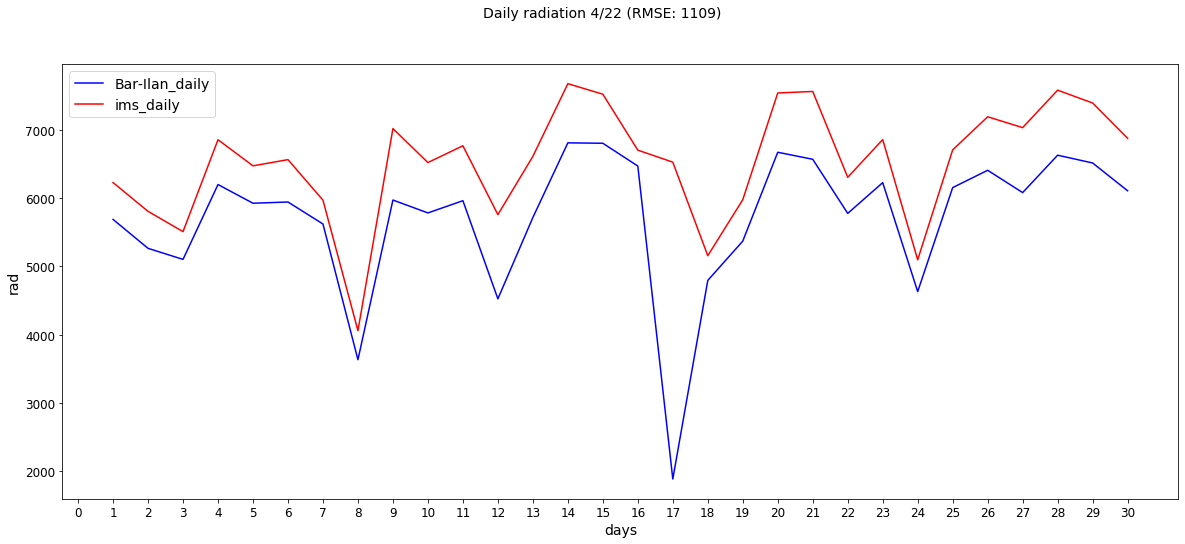

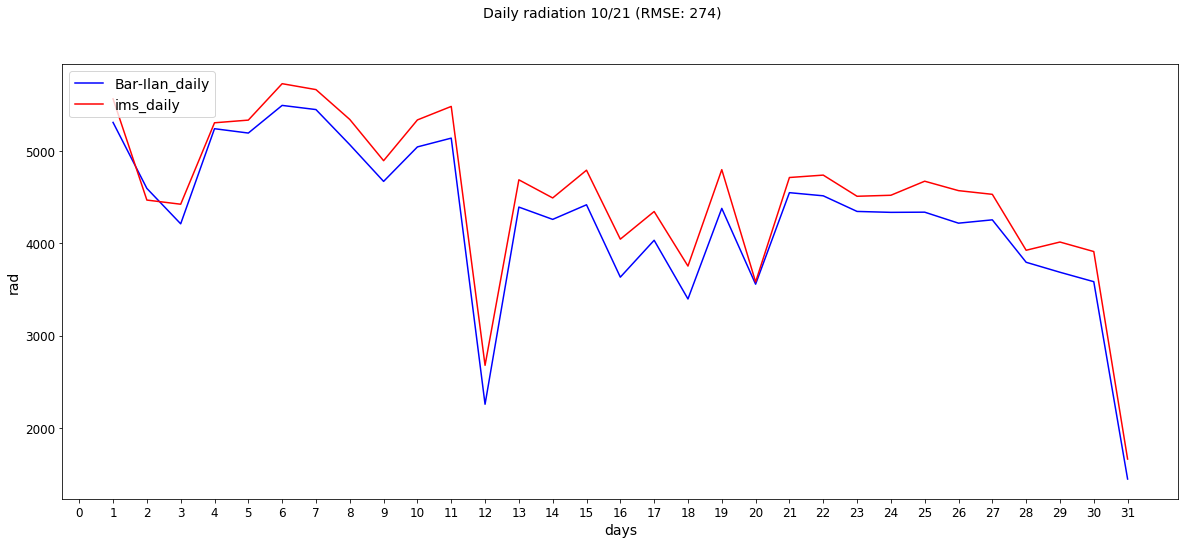

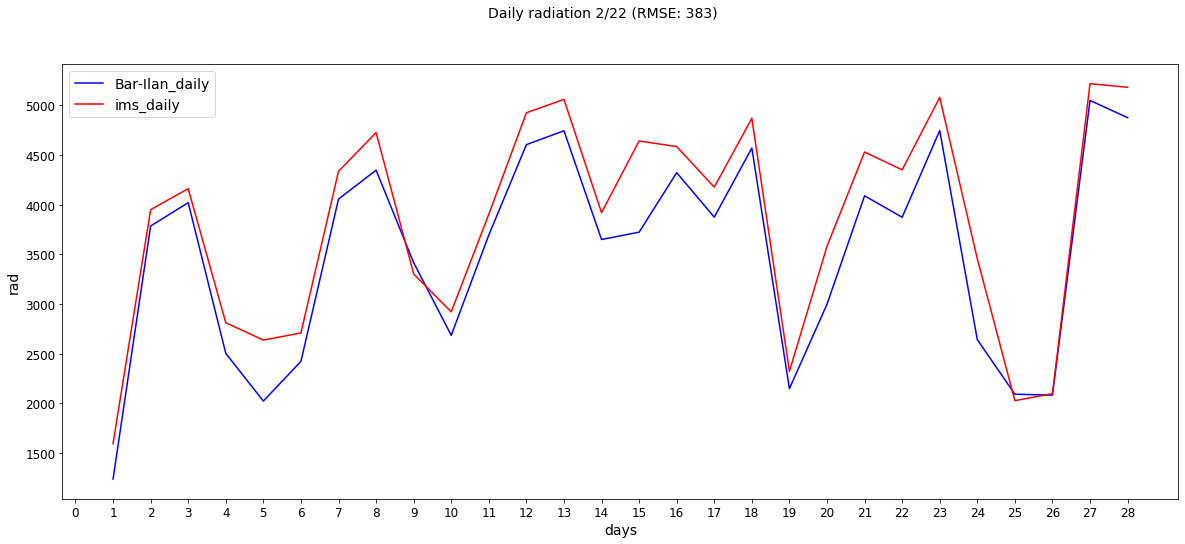

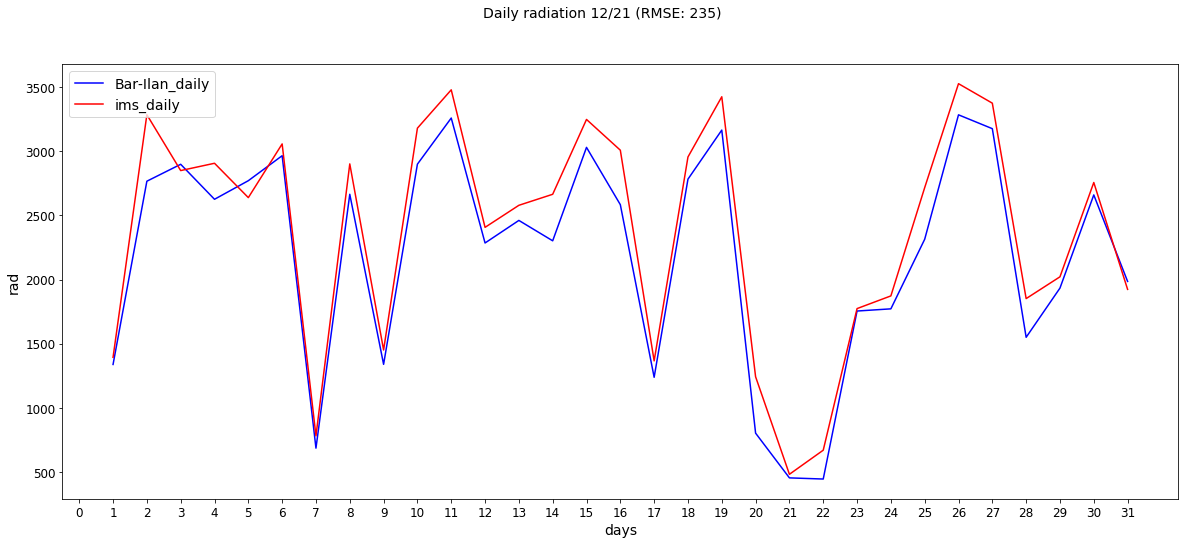

In [70]:
count = 0
rmse_dict = {}
rmse_file = '/Users/alonhrl/Documents/Alon/MA-MSC/development/Radiation-data/rmse.csv'
#iterate recursively over all CSV files in the directory

for dirpath, dirs, files in os.walk(imsInputDir):
    for filename in files:
        fname = os.path.join(dirpath,filename)
        file_name, file_extension = os.path.splitext(filename)
                
        if file_extension == '.csv':
            month, year = get_file_month_year(fname)
            count +=1
            #load IMS data (file should not include non-numbers, add first row to be the hours, i.e. 6,7,8...)
            print("Processing: %s" %(fname))

            imsDaySum = generate_ims_day_radiation_array(fname)
            
            print("imsDaySum")
            print (imsDaySum)
            
            #find matching Eumetsat data file
            barIlan_data_file = None
            barIlan_data_file = find_matching_barIlan_file(month, year)
            if( barIlan_data_file is not None):
                print("Found Bar-Ilan matching file: %s" % (barIlan_data_file))
                barIlanDaySum = generate_bar_Ilan_day_radiation_array(barIlan_data_file)
                print("barIlanDaySum")
                print(barIlanDaySum)
                rmse = calculate_rmse(imsDaySum[1], barIlanDaySum)
                rmse_dict[month] = rmse
                
                fileName = 'bar_ilan-' + str(month).zfill(2) + '-' + str(year)[2:] + '.png'
                
                plot_radiation_graph(month, year, imsDaySum, barIlanDaySum, fileName, rmse)
            else:
                print("Bar-Ilan matching file for %02d-%02d is missing !!!" %(month, year))
                        
            print("done!")
            
            #write_rmse_to_file(rmse_file, rmse_list)
print("RMSE: ", rmse_dict)
print ("Processed %d files!" % (count))
        